# RAG Architucture

![image.png](v)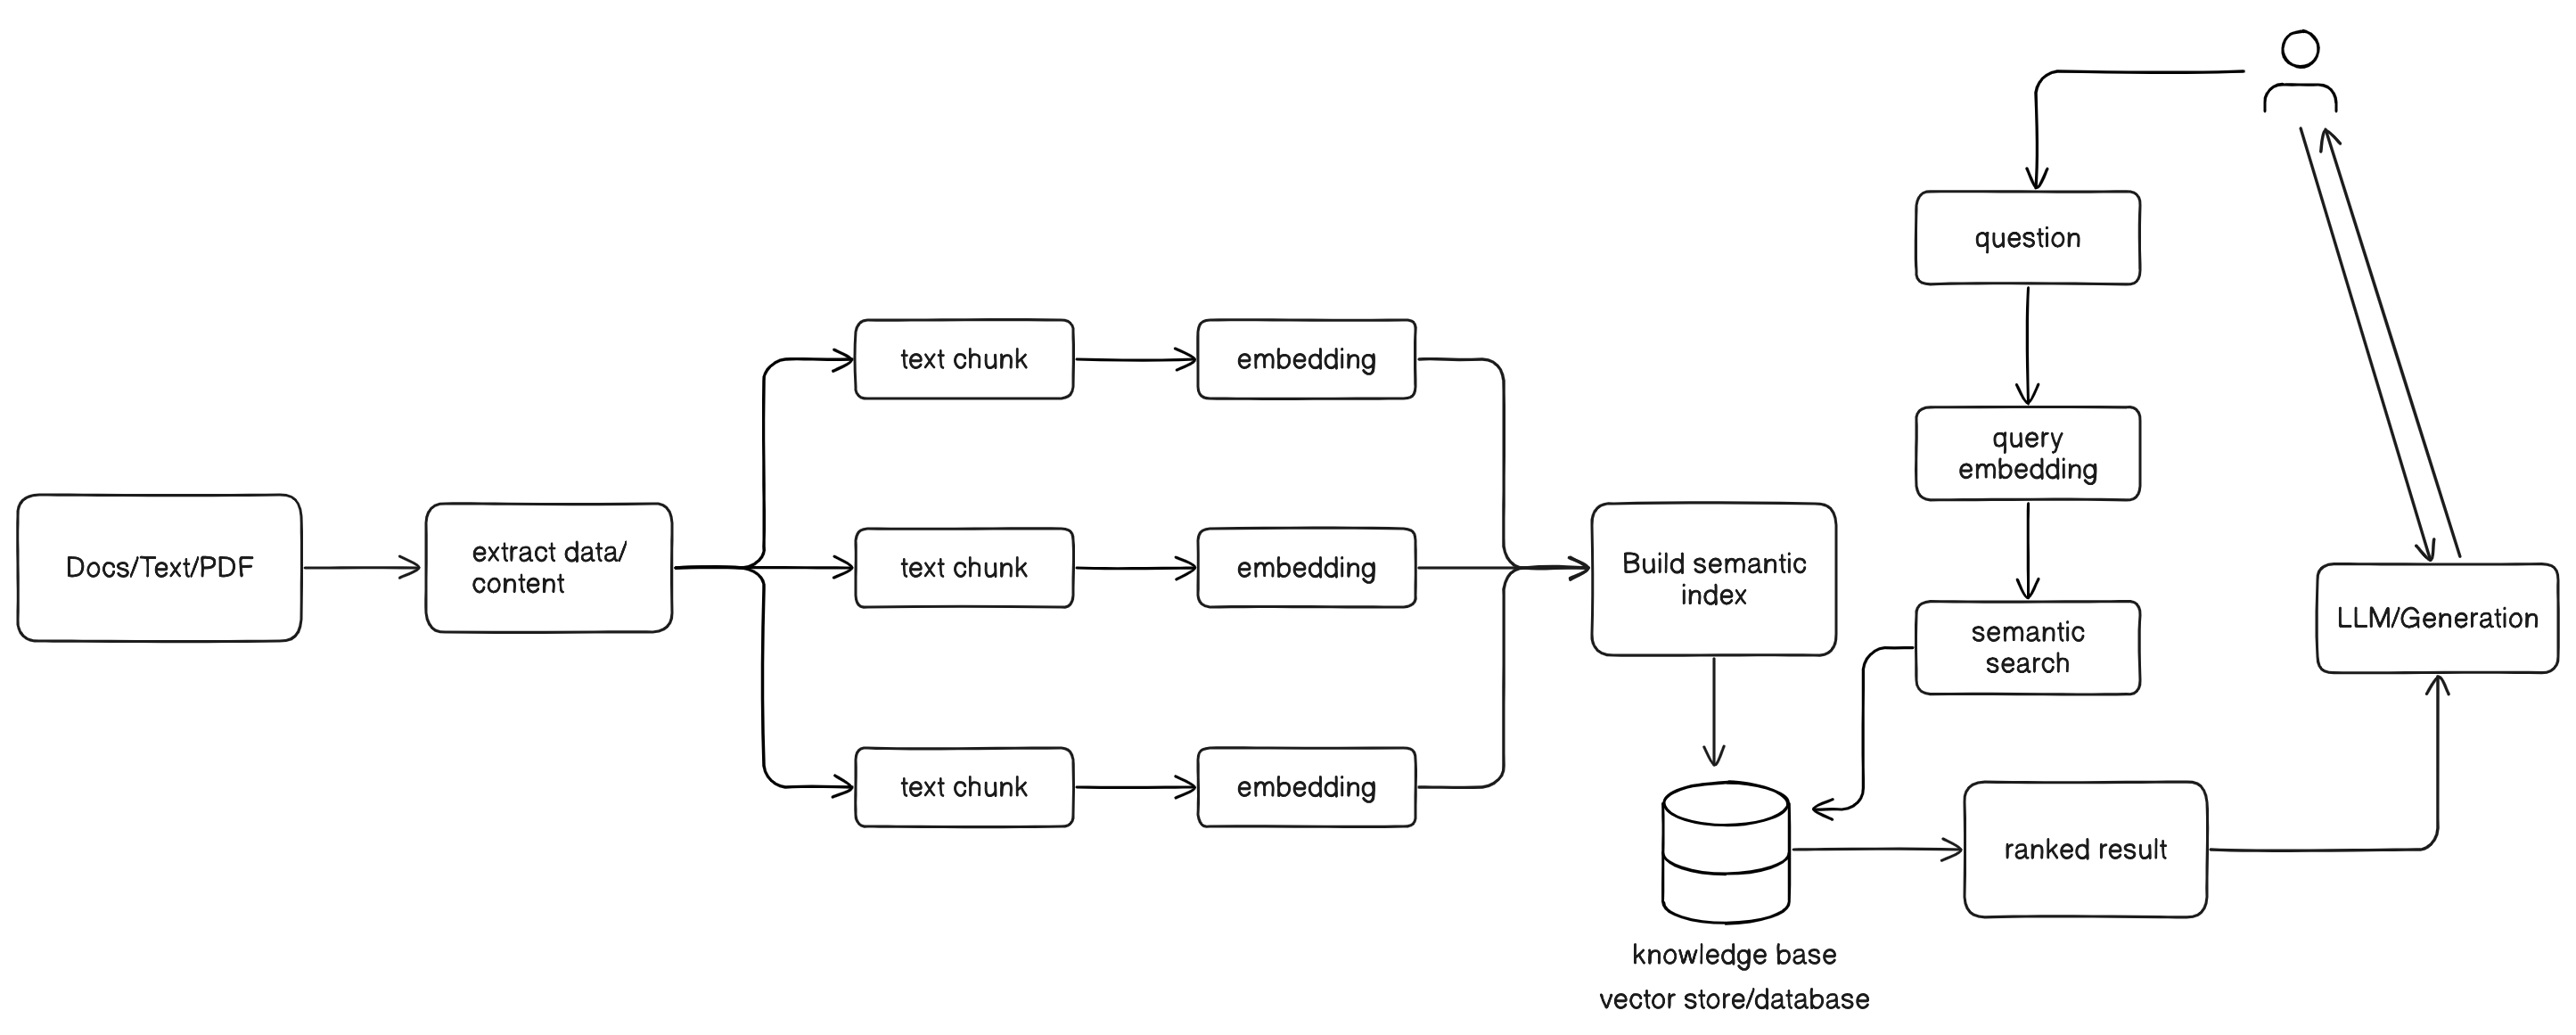

### First install required packages

In [ ]:
%%capture --no-stderr
%pip install langchain langchain_community langchain_core langchain_google_genai
%pip install faiss-cpu pypdf

In [ ]:
%pip install rapidocr-onnxruntime

In [ ]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/feisty-lambda-420416-5d80219f7d8e.json"

# Initiliaze the LLM Model

In [ ]:
import os
from google.colab import userdata
gemini_api_key = userdata.get("GEMINI_API_KEY")

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = gemini_api_key, temperature=0.5)

In [ ]:
llm.invoke("HI")

AIMessage(content='Hi there! What can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ed8d235f-7e71-486d-bf2d-a680cb472b23-0', usage_metadata={'input_tokens': 2, 'output_tokens': 12, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

# Extract Data

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("/content/RAG (1).pdf", extract_images=True)
pages = loader.load()

In [ ]:
print(pages)

[Document(metadata={'source': '/content/RAG (1).pdf', 'page': 0}, page_content='Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,\nAleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,\nMike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†\n†Facebook AI Research; ‡University College London; ⋆New York University;\nplewis@fb.com\nAbstract\nLarge pre-trained language models have been shown to store factual knowledge\nin their parameters, and achieve state-of-the-art results when ﬁne-tuned on down-\nstream NLP tasks. However, their ability to access and precisely manipulate knowl-\nedge is still limited, and hence on knowledge-intensive tasks, their performance\nlags behind task-speciﬁc architectures. Additionally, providing provenance for their\ndecisions and updating their world knowledge remain open research problems. Pre-\ntrained models with a differentiable access mechanism to

In [ ]:
pages[0]

Document(metadata={'source': '/content/RAG (1).pdf', 'page': 0}, page_content='Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,\nAleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,\nMike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†\n†Facebook AI Research; ‡University College London; ⋆New York University;\nplewis@fb.com\nAbstract\nLarge pre-trained language models have been shown to store factual knowledge\nin their parameters, and achieve state-of-the-art results when ﬁne-tuned on down-\nstream NLP tasks. However, their ability to access and precisely manipulate knowl-\nedge is still limited, and hence on knowledge-intensive tasks, their performance\nlags behind task-speciﬁc architectures. Additionally, providing provenance for their\ndecisions and updating their world knowledge remain open research problems. Pre-\ntrained models with a differentiable access mechanism to 

# Convert Data into chunks

In [ ]:
from langchain.text_splitter import  RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 100,
    length_function = len,
)
docs = text_splitter.split_documents(pages)

In [ ]:
docs

[Document(metadata={'source': '/content/RAG (1).pdf', 'page': 0}, page_content='Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,\nAleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,\nMike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†\n†Facebook AI Research; ‡University College London; ⋆New York University;\nplewis@fb.com\nAbstract\nLarge pre-trained language models have been shown to store factual knowledge\nin their parameters, and achieve state-of-the-art results when ﬁne-tuned on down-\nstream NLP tasks. However, their ability to access and precisely manipulate knowl-\nedge is still limited, and hence on knowledge-intensive tasks, their performance\nlags behind task-speciﬁc architectures. Additionally, providing provenance for their\ndecisions and updating their world knowledge remain open research problems. Pre-\ntrained models with a differentiable access mechanism to

# Create Embedding

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", api_key=gemini_api_key)

In [ ]:
# test for embedding is working or not
vectors = embeddings.embed_query("How are you")
len(vectors)

768

# Create Vector Store for similarity search

In [ ]:
from langchain_community.vectorstores import FAISS
db = FAISS.from_documents(docs, embeddings)

In [ ]:
query = "RAG-Sequence Model"
retrieved_result = db.similarity_search(query, k=3)

In [ ]:
print(retrieved_result)

[Document(metadata={'source': '/content/RAG (1).pdf', 'page': 3}, page_content='RAG-Sequence For RAG-Sequence, the likelihood p(y|x) does not break into a conventional per-\ntoken likelihood, hence we cannot solve it with a single beam search. Instead, we run beam search for\neach document z, scoring each hypothesis using pθ(yi|x,z,y 1:i−1). This yields a set of hypotheses\nY, some of which may not have appeared in the beams of all documents. To estimate the probability\nof an hypothesis y we run an additional forward pass for each document z for which y does not\nappear in the beam, multiply generator probability with pη(z|x) and then sum the probabilities across\nbeams for the marginals. We refer to this decoding procedure as “Thorough Decoding.” For longer\noutput sequences, |Y|can become large, requiring many forward passes. For more efﬁcient decoding,\nwe can make a further approximation that pθ(y|x,zi) ≈0 where ywas not generated during beam\nsearch from x,zi. This avoids the nee

In [ ]:
print(retrieved_result[0].page_content)

RAG-Sequence For RAG-Sequence, the likelihood p(y|x) does not break into a conventional per-
token likelihood, hence we cannot solve it with a single beam search. Instead, we run beam search for
each document z, scoring each hypothesis using pθ(yi|x,z,y 1:i−1). This yields a set of hypotheses
Y, some of which may not have appeared in the beams of all documents. To estimate the probability
of an hypothesis y we run an additional forward pass for each document z for which y does not
appear in the beam, multiply generator probability with pη(z|x) and then sum the probabilities across
beams for the marginals. We refer to this decoding procedure as “Thorough Decoding.” For longer
output sequences, |Y|can become large, requiring many forward passes. For more efﬁcient decoding,
we can make a further approximation that pθ(y|x,zi) ≈0 where ywas not generated during beam
search from x,zi. This avoids the need to run additional forward passes once the candidate set Y has


In [ ]:
from langchain.prompts import ChatPromptTemplate
template = """
  Answer the question as detailed as possible from the provided context, make sure to provide all the details, if the answer is not in
    provided context just say, "answer is not available in the context", don't provide the wrong answer\n\n
    Context:\n {context}?\n
    Question: \n{question}\n
    Answer:
"""

In [ ]:
prompt_template = ChatPromptTemplate.from_template(template)

In [ ]:
prompt_template

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='\n  Answer the question as detailed as possible from the provided context, make sure to provide all the details, if the answer is not in\n    provided context just say, "answer is not available in the context", don\'t provide the wrong answer\n\n\n    Context:\n {context}?\n\n    Question: \n{question}\n\n    Answer:\n'), additional_kwargs={})])

In [ ]:
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

In [ ]:
output_parser = StrOutputParser()

In [ ]:
retriever = db.as_retriever()

In [ ]:
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt_template
    | llm
    | output_parser
)

In [ ]:
print(rag_chain.invoke("full detailed provide ndex hot-swapping ?"))

An advantage of non-parametric memory models like RAG is that knowledge can be easily updated at test time. Parametric-only models like T5 or BART need further training to update their behavior as the world changes. To demonstrate, we build an index using the DrQA [5] Wikipedia dump from December 2016 and compare outputs from RAG using this index to the newer index from our main results (December 2018). We prepare a list of 82 world leaders who had changed 

